# Online Payment Fraud Detection using Machine Learning

## Import the Libraries and Load the dataset

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score as ras
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("Online Payment Fraud Detection data.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [3]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


## Data Visualization

In [4]:
obj = (df.dtypes == 'object')
object_cols = list(obj[obj].index)
print("categorical variables:", len(object_cols))

int = (df.dtypes == 'int')
num_cols = list(int[int].index)
print("Integer variables:", len(num_cols))

fl = (df.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:", len(fl_cols))


categorical variables: 3
Integer variables: 3
Float variables: 5


### count plot of the Payment type column 

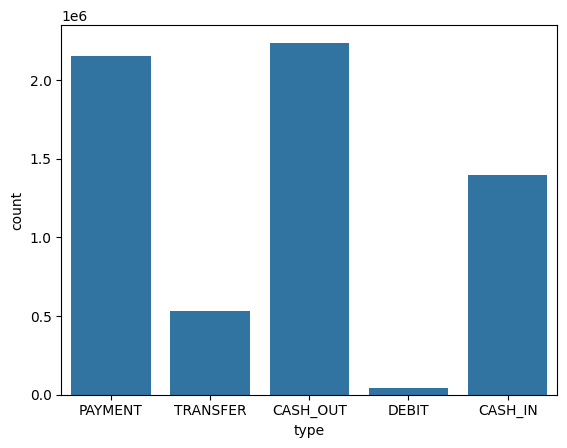

In [5]:
sns.countplot(x='type', data=df)
plt.show()

### So let's check bar plot for analyzing Type and amount column simultaneously.

<Axes: xlabel='type', ylabel='amount'>

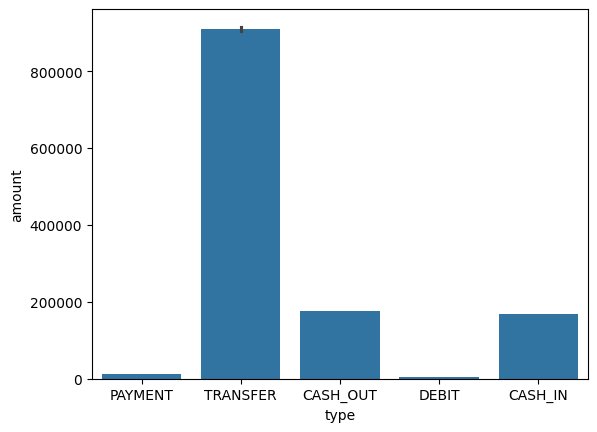

In [6]:
sns.barplot(x='type', y='amount', data=df)


### Both the graph clearly shows that mostly the type cash_out and transfer are maximum in count and as well as in amount. 
### So let's check distribution of data among both the prediction values

In [7]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

### The dataset is already in same count. So there is no need of sampling.
### Now let's see the distribution of the step column using distplot.

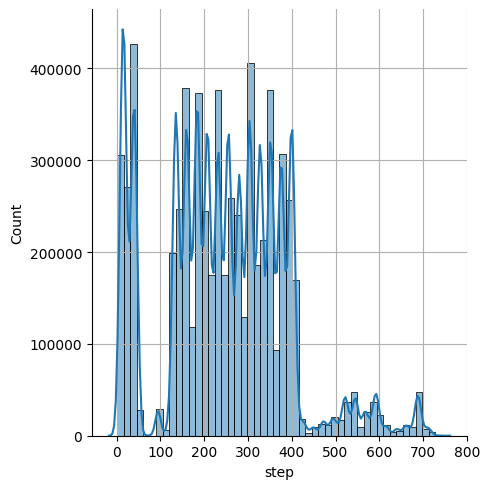

In [8]:
sns.displot(df['step'], bins=50, kde=True, kde_kws=dict(cut=3))
plt.grid(True)

### The graph shows the maximum distribution among 200 to 400 of step.
### Now, Let's find the correlation among different features using Heatmap

<Axes: >

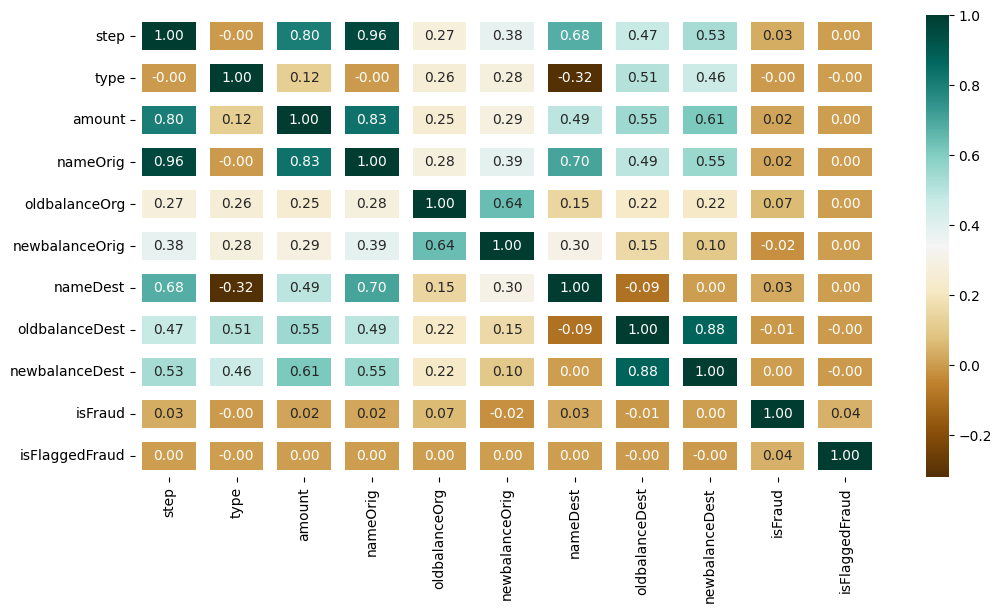

In [9]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.apply(lambda x: pd.factorize(x)[0]).corr(), cmap='BrBG',	fmt='.2f',linewidths=10, annot=True)

# Data Preprocessing
### 1 Encoding of Type column
### 2 Dropping irrelevant columns like nameOrig, nameDest
### 3 Data Splitting

In [10]:
type_new = pd.get_dummies(df['type'], drop_first= True)
data_new = pd.concat([df, type_new], axis=1)
data_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,False,False,True,False
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,False,False,True,False
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,False,False,False,True
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,True,False,False,False
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,False,False,True,False


### Once we done with the encoding, now we can drop the irrelevant columns

In [11]:
x = data_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = data_new['isFraud']
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.2, random_state=42)

# Model Training

#### LogisticRegression: Predicts the probability that input data belongs to a specific category or not (mainly used for binary classification).

#### XGBClassifier: Uses multiple decision trees built one after another, improving each time. It assigns weights and focuses on errors to boost performance.

#### SVC (Support Vector Classifier): Finds the best boundary (hyperplane) that separates classes and classifies new data based on which side it falls.

#### RandomForestClassifier: Builds multiple decision trees from random parts of the data and uses majority voting from all trees to make the final decision.

In [12]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
models = [LogisticRegression(max_iter=100), XGBClassifier(), RandomForestClassifier(n_estimators=7, criterion='entropy', random_state=7)]

for i in range(len(models)):
    models[i].fit(x_train_scaled, y_train)
    
    train_preds = models[i].predict_proba(x_train_scaled)[:, 1]
    print('Training Accuracy : ', ras(y_train, train_preds))
    
    y_preds = models[i].predict_proba(x_test_scaled)[:, 1]
    print('Validation Accuracy : ', ras(y_test, y_preds))
    print()

Training Accuracy :  0.9816746039743297
Validation Accuracy :  0.9824396946223483

Training Accuracy :  0.7757043532970154
Validation Accuracy :  0.7731009060878062

Training Accuracy :  0.9999994192991448
Validation Accuracy :  0.9650481283741416



# Model Evaluation
### The best-performed model is XGBClassifier. Let's plot the Confusion Matrix for the same.

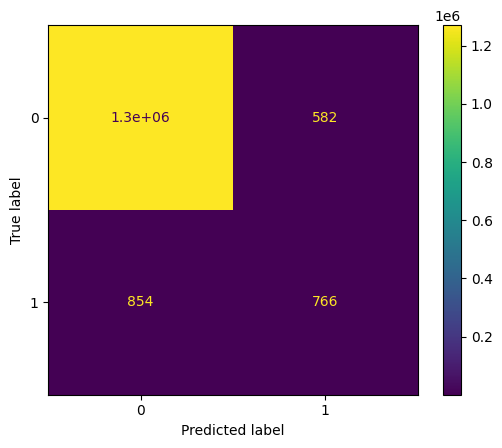

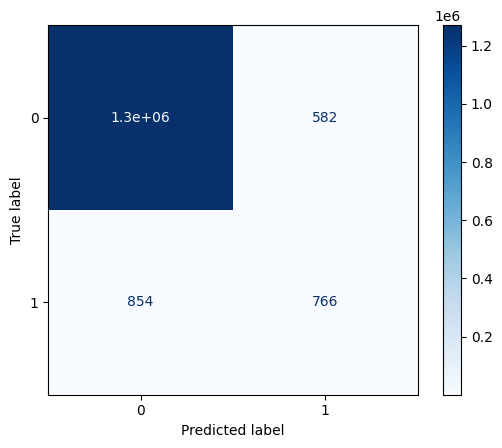

In [13]:
cm = ConfusionMatrixDisplay.from_estimator(models[1], x_test_scaled, y_test) 
cm.plot(cmap='Blues')